In [1]:
import numpy as np
import torch
import torchvision

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

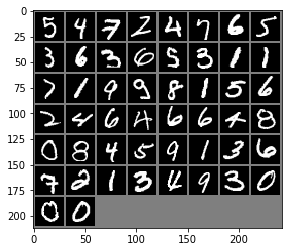

Process Process-2:
Traceback (most recent call last):
Process Process-1:
Traceback (most recent call last):
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/mul

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [7]:
trainset[0][0].size()

torch.Size([1, 28, 28])

In [80]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):

    def __init__(self, nc=1, ngf=16, nz=100):
        super(GeneratorNetwork, self).__init__()
        self.input_dim = nz
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(nz,ngf*4,kernel_size=4),
                                 nn.BatchNorm2d(ngf*4),
                                 nn.ReLU())
        # 4 x 4
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(ngf*4,ngf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*2),
                                 nn.ReLU())
        # 8 x 8
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(ngf*2,ngf,kernel_size=4,stride=2,padding=2),
                                 nn.BatchNorm2d(ngf),
                                 nn.ReLU())
        # 16 x 16
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(ngf,nc,kernel_size=4,stride=2,padding=1),
                                 nn.Tanh())

    def forward(self,x):
        x = x.view(-1, 100, 1, 1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, K):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(K)
        self.K = K
    
    def build_net(self, K):
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [81]:
from bgan import BGAN

In [82]:
batch_size = 50
z_dim = 100

In [216]:
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork()
disc = DiscriminatorNetwork(2)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, disc, prior, alpha=.01, eta=1e-4, num_data=len(trainset), disc_lr=1e-5, gen_observed=500)
samples = []

In [217]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.data.numpy()))

torch.Size([100, 64, 4, 4]) 4.62979
torch.Size([64]) 0.102023
torch.Size([64]) 5.18193
torch.Size([64]) 0.0
torch.Size([64, 32, 4, 4]) 3.26651
torch.Size([32]) 0.104714
torch.Size([32]) 3.43867
torch.Size([32]) 0.0
torch.Size([32, 16, 4, 4]) 2.31644
torch.Size([16]) 0.100687
torch.Size([16]) 2.10896
torch.Size([16]) 0.0
torch.Size([16, 1, 4, 4]) 0.552423
torch.Size([1]) 0.0449422


## Training

In [218]:
num_samples = 100

In [ ]:
if isinstance(samples, np.ndarray):
    samples = [samples]
    
for epoch in range(500):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.step(batch)
#         print(i)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv)
        print('\t', d_loss.data.numpy()[0], g_loss.data.numpy()[0])
    if not epoch%1:
        print(epoch)
    if not epoch%1:
        samples.append(bgan.sample(num_samples).data.numpy())
samples = np.vstack(samples)

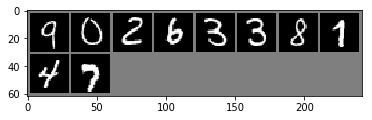

In [296]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [297]:
# samples_arr = np.array(samples[:-2])
# samples_ = samples[-2:]
# samples = [samples_arr]
# samples.append(samples_[0])
# samples.append(samples_[1])
# samples = np.vstack(samples)

In [298]:
# samples = bgan.sample(100).data.numpy()

In [299]:
# samples_arr = np.vstack(samples)
samples_arr = samples

In [300]:
samples_arr.shape

AttributeError: 'list' object has no attribute 'shape'

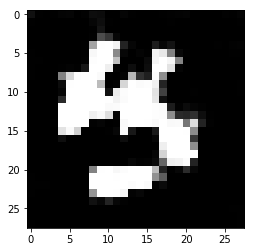

In [291]:
plt.imshow((samples_arr[-1, 0] + 1)/2, cmap='gray')

In [292]:
np.max(batch.numpy())

1.0

In [293]:
samples_arr.shape

(3000, 1, 28, 28)

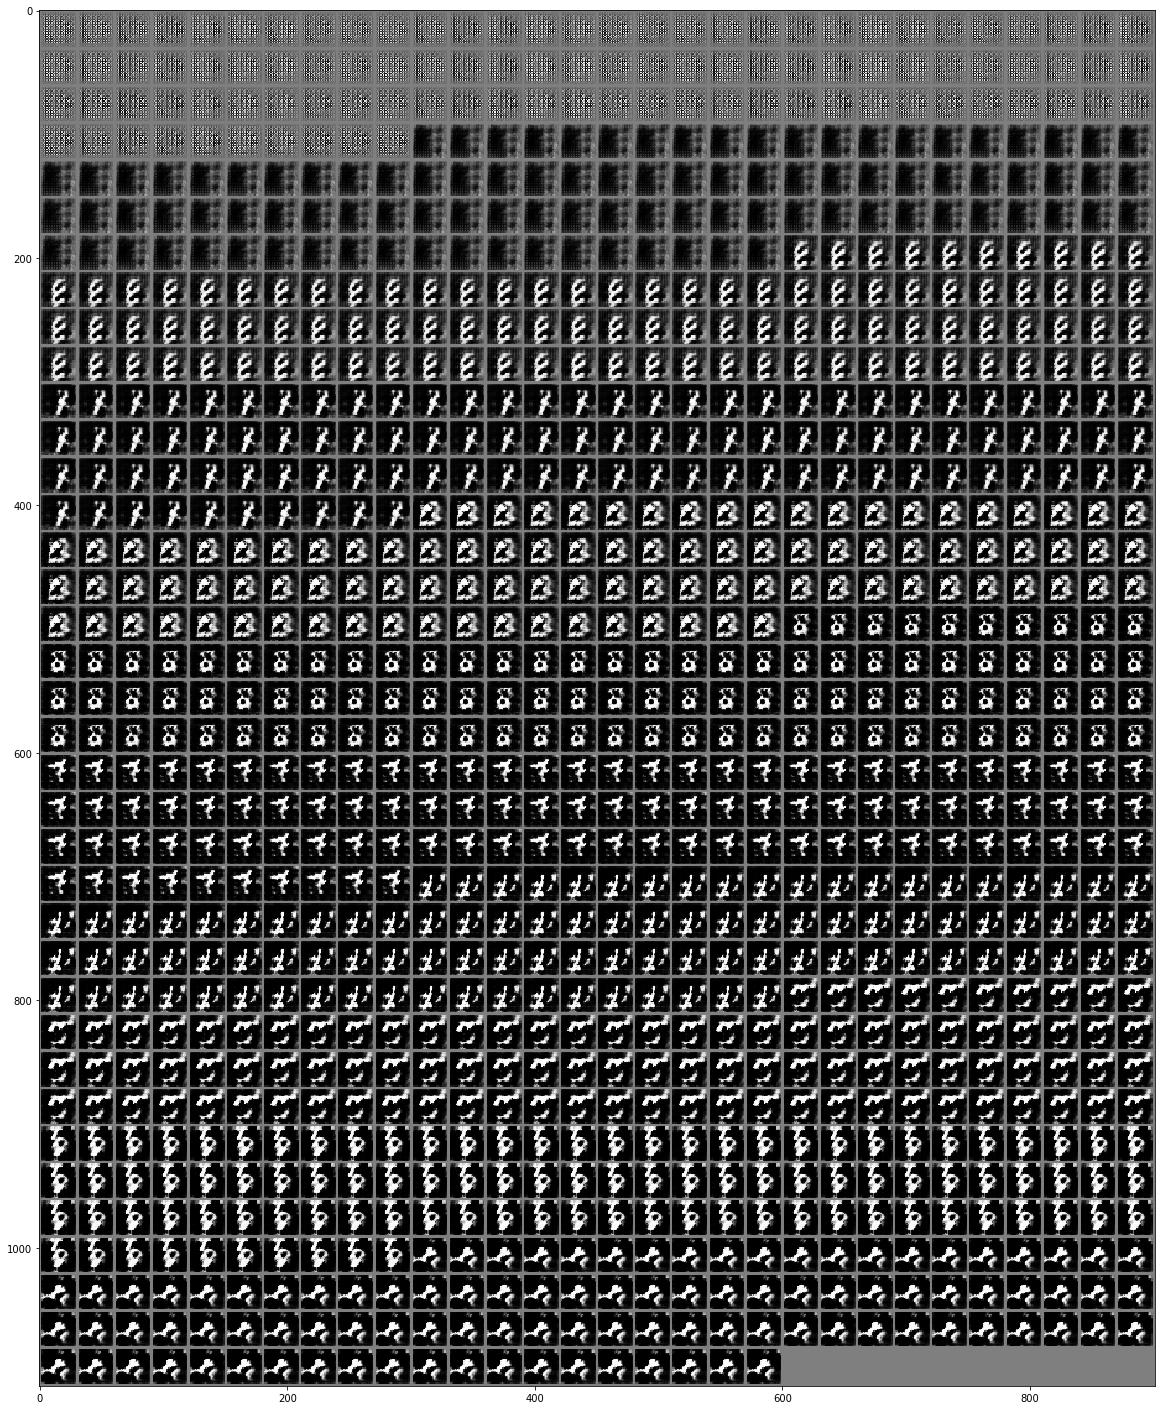

In [294]:
plt.figure(figsize=(20, 50))
show_epochs = [0, 10]
start, finish = show_epochs[0] * num_samples, (show_epochs[1]+1) * num_samples
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[start:finish]), nrow=30))


In [675]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())[:, 0]

In [676]:
sample_probs

Variable containing:
 0.7485
 0.7704
 0.7569
 0.6473
 0.8342
 0.6627
 0.8117
 0.7938
 0.6807
 0.7110
 0.6903
 0.7226
 0.8014
 0.6831
 0.7772
 0.8616
 0.8307
 0.7458
 0.7753
 0.8589
 0.8388
 0.7404
 0.8264
 0.8411
 0.7829
 0.8383
 0.8324
 0.7904
 0.8684
 0.8357
 0.8445
 0.8165
 0.8179
 0.7921
 0.7193
 0.8361
 0.8302
 0.8666
 0.7999
 0.8240
 0.7699
 0.8135
 0.8035
 0.8570
 0.8836
 0.8639
 0.8098
 0.8612
 0.8107
 0.8431
 0.8023
 0.8840
 0.8386
 0.8875
 0.8985
 0.8661
 0.8427
 0.8913
 0.8406
 0.7751
 0.8792
 0.7851
 0.8806
 0.7856
 0.9126
 0.8588
 0.8059
 0.8232
 0.8213
 0.7779
 0.8160
 0.8396
 0.8653
 0.8418
 0.8574
 0.8800
 0.8665
 0.8983
 0.8881
 0.8902
 0.8438
 0.8018
 0.7894
 0.8795
 0.8914
 0.8428
 0.8187
 0.8946
 0.8021
 0.8338
 0.8171
 0.8640
 0.8746
 0.7876
 0.8423
 0.8562
 0.8346
 0.8559
 0.8738
 0.8135
[torch.cuda.FloatTensor of size 100 (GPU 0)]

In [679]:
disc(Variable(batch).cuda())[:, 0]

Variable containing:
 0.7235
 0.7993
 0.7501
 0.8424
 0.4019
 0.8174
 0.7988
 0.8607
 0.8839
 0.7365
 0.8428
 0.8265
 0.6104
 0.7270
 0.7838
 0.8431
 0.8651
 0.8589
 0.7899
 0.8175
 0.7914
 0.8455
 0.7148
 0.7867
 0.5143
 0.7957
 0.8807
 0.7820
 0.7927
 0.7861
 0.7605
 0.7809
 0.7754
 0.8324
 0.8999
 0.8361
 0.7216
 0.8109
 0.8405
 0.8527
 0.8221
 0.8806
 0.7403
 0.7628
 0.8398
 0.7767
 0.6398
 0.7129
 0.8650
 0.7762
[torch.cuda.FloatTensor of size 50 (GPU 0)]

In [60]:
idx = np.where(sample_probs > 0.5)
good_samples = samples[idx]

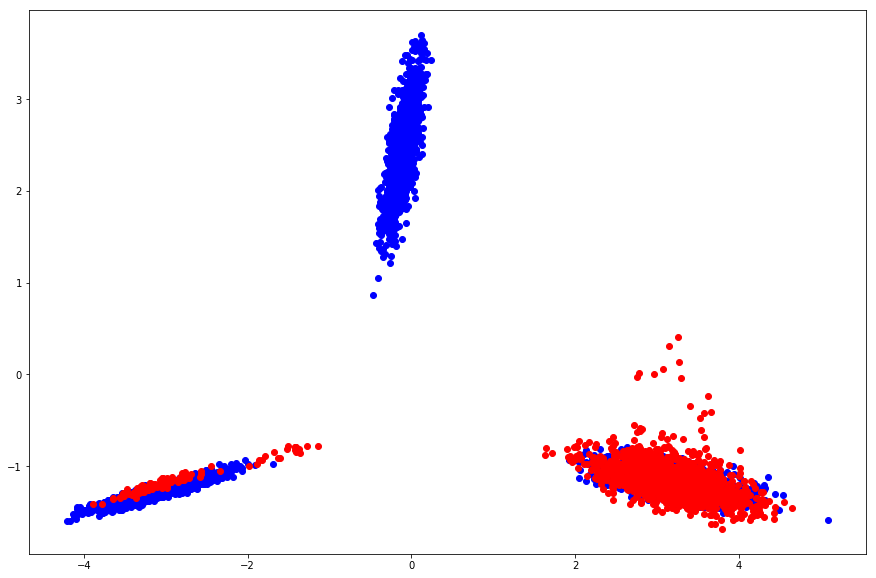

In [61]:
plt.figure(figsize=(15, 10))
x_r, x_f = pca(data.X.numpy(), good_samples)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[:, 0], x_f[:, 1], 'ro')
# plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

In [62]:
true_probs = disc(Variable(data.X))[:, 0].data.numpy()
np.min(true_probs)

0.29538473

In [63]:
bad_idx = np.where(true_probs < 0.5)
bad_data = data.X.numpy()[bad_idx]

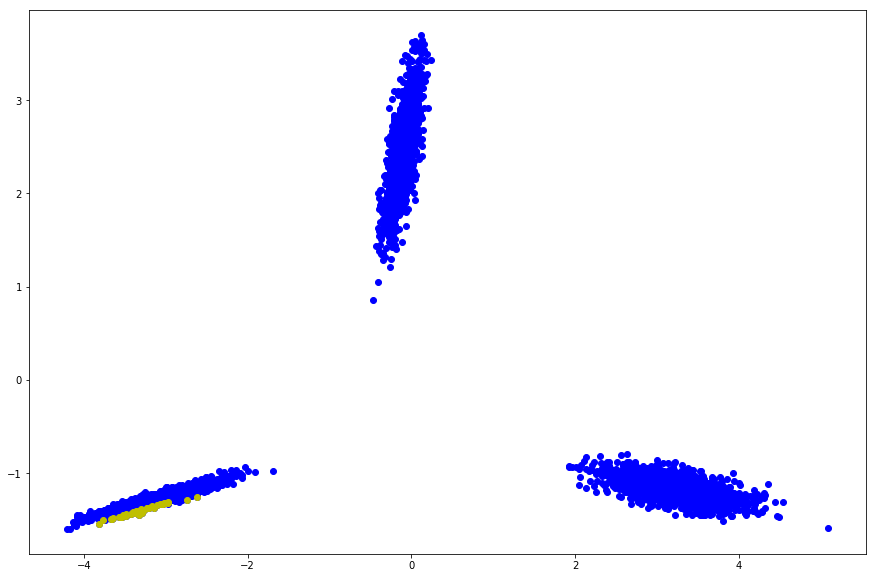

In [64]:
plt.figure(figsize=(15, 10))
x_r, x_b = pca(data.X.numpy(), bad_data)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_b[:, 0], x_b[:, 1], 'yo')